In [1]:
import os
import torch
import datetime
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import DataLoader, random_split

import random
random.seed(42)

# Datasets
- After running redataset.ipynb, check the **dataset** folder
- The data set is randomly divided into training set and testing set according to 8:2.

In [2]:
path = '../front_dl/dataset'

In [3]:
full_data = torchvision.datasets.ImageFolder(root=path,transform=torchvision.transforms.ToTensor()) 

train_size = int(len(full_data)*0.8)
test_size = len(full_data) - train_size

train_dataset, test_dataset =random_split(full_data, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8, shuffle=False)

In [4]:
print(f"train size:{train_size}")
print(f"test size:{test_size}")

train size:50393
test size:12599


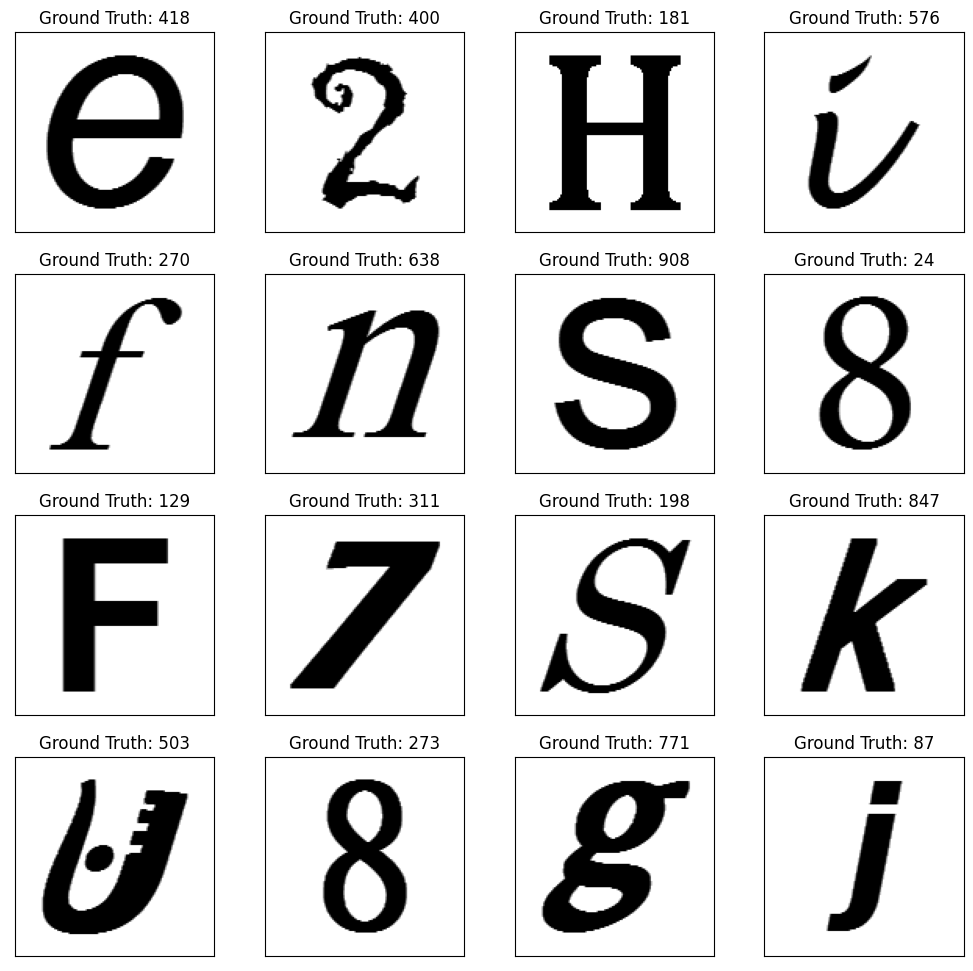

In [5]:
for i, data in enumerate(train_loader):
    x, y = data
    
    fig = plt.figure(figsize=(10,10),dpi=100)
    for j in range(16):
        plt.subplot(4,4,j+1)
        plt.tight_layout()
        plt.imshow(np.array(x[j][0][:][:]), cmap='gray')
        plt.title("Ground Truth: {}".format(y[j])) 
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break

# Model
- resnet50

In [6]:
output = len(os.listdir(path))

In [7]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(in_features=2048, out_features=output, bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Using Gpu or Cpu 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cuda', index=0)

In [9]:
def training(model, train_dl, test_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []
    begin = datetime.datetime.now()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        train_accs.append(acc)
        train_losses.append(avg_loss)
        
        test_acc, test_loss = testing(model, test_dl)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}',end=" ")
        print(f'Test Accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}, Time: {datetime.datetime.now()-begin}')
        
        

    print('Finished Training')
    return train_accs, train_losses, test_accs, test_losses

def testing (model, test_dl):
    criterion = nn.CrossEntropyLoss()
    
    correct_prediction = 0
    total_prediction = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    num_batches = len(test_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    
    return acc, avg_loss

In [10]:
epochs = 30

In [11]:
train_accs, train_losses, test_accs, test_losses= training(model,train_loader,test_loader,epochs)

Epoch: 0, Loss: 6.48, Accuracy: 0.01 Test Accuracy: 0.02, Test loss: 5.47, Time: 0:01:48.557783
Epoch: 1, Loss: 4.70, Accuracy: 0.05 Test Accuracy: 0.08, Test loss: 4.22, Time: 0:03:35.884003
Epoch: 2, Loss: 3.87, Accuracy: 0.11 Test Accuracy: 0.14, Test loss: 3.59, Time: 0:05:23.275430
Epoch: 3, Loss: 3.39, Accuracy: 0.16 Test Accuracy: 0.17, Test loss: 3.28, Time: 0:07:10.974359
Epoch: 4, Loss: 3.01, Accuracy: 0.21 Test Accuracy: 0.22, Test loss: 2.96, Time: 0:08:59.062920
Epoch: 5, Loss: 2.71, Accuracy: 0.26 Test Accuracy: 0.25, Test loss: 2.78, Time: 0:10:46.174862
Epoch: 6, Loss: 2.45, Accuracy: 0.31 Test Accuracy: 0.29, Test loss: 2.52, Time: 0:12:33.778992
Epoch: 7, Loss: 2.23, Accuracy: 0.36 Test Accuracy: 0.32, Test loss: 2.39, Time: 0:14:22.629619
Epoch: 8, Loss: 2.05, Accuracy: 0.39 Test Accuracy: 0.34, Test loss: 2.28, Time: 0:16:12.103840
Epoch: 9, Loss: 1.84, Accuracy: 0.44 Test Accuracy: 0.38, Test loss: 2.05, Time: 0:18:00.481376
Epoch: 10, Loss: 1.62, Accuracy: 0.49 Te

# evaluate

In [12]:
def result_plot(train_accs, train_losses, test_accs, test_losses):
    epochs = len(train_accs)
    
    plt.subplot(1,2,1)
    plt.plot(np.linspace(1,epochs,epochs),train_accs,label="train_acc")
    plt.plot(np.linspace(1,epochs,epochs),test_accs,label="test_acc")
    plt.title("ACC Plot")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(np.linspace(1,epochs,epochs),train_losses,label="train_loss")
    plt.plot(np.linspace(1,epochs,epochs),test_losses,label="test_loss")
    plt.title("LOSS Plot")
    plt.legend()
    
    plt.show()

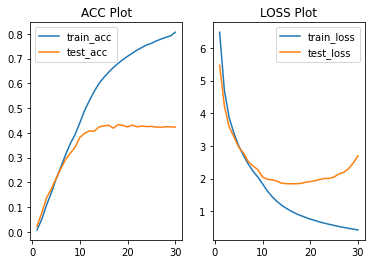

In [13]:
result_plot(train_accs, train_losses, test_accs, test_losses)